In [1]:
import os
import gc
import cv2
import json
import time
import shutil
import numpy as np
from tqdm import tqdm
import mediapipe as mp
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ThreadPoolExecutor
from IPython.display import clear_output, FileLink

In [ ]:
import json

#Load Json 
json_file_path = r'your path (old.json was used)'


with open(json_file_path, 'r') as json_file:
    all_data = json.load(json_file)


print(all_data)  #print data


[{'gloss': 'book', 'instances': [{'bbox': [385, 37, 885, 720], 'fps': 25, 'frame_end': -1, 'frame_start': 1, 'instance_id': 0, 'signer_id': 118, 'source': 'aslbrick', 'split': 'train', 'url': 'C:/Users/shaga/Desktop/Thesis/videos/69241.mp4', 'variation_id': 0, 'video_id': '69241'}, {'bbox': [462, 44, 949, 720], 'fps': 25, 'frame_end': -1, 'frame_start': 1, 'instance_id': 10, 'signer_id': 31, 'source': 'signschool', 'split': 'train', 'url': 'C:/Users/shaga/Desktop/Thesis/videos/07069.mp4', 'variation_id': 0, 'video_id': '07069'}, {'bbox': [234, 17, 524, 414], 'fps': 25, 'frame_end': -1, 'frame_start': 1, 'instance_id': 17, 'signer_id': 36, 'source': 'startasl', 'split': 'train', 'url': 'C:/Users/shaga/Desktop/Thesis/videos/07068.mp4', 'variation_id': 0, 'video_id': '07068'}, {'bbox': [131, 26, 526, 480], 'fps': 25, 'frame_end': -1, 'frame_start': 1, 'instance_id': 22, 'signer_id': 59, 'source': 'asldeafined', 'split': 'train', 'url': 'C:/Users/shaga/Desktop/Thesis/videos/07070.mp4', 'va

In [ ]:
import json
import os
from tqdm import tqdm

# Specify to the JSON file
json_file_path = r'your path (old.json was used)'

with open(json_file_path, 'r') as json_file:
    all_data = json.load(json_file)

# Define the directories for where the video files are
video_dir = r'video path with dataset'  # Update the correct path


data = []

# Loop through each entry in the loaded JSON data
for i in tqdm(range(len(all_data)), ncols=100):
    gloss = all_data[i]['gloss']
    instances = all_data[i]['instances']
    
    for instance in instances:
        # Extract the video ID and determine the path
        video_id = instance['video_id']
        video_path = ''
        
        # Check if video exists in the main directory or backup directory
        if os.path.exists(os.path.join(video_dir, f'{video_id}.mp4')):
            video_path = os.path.join(video_dir, f'{video_id}.mp4')
        else:
            continue  
        
        frame_start = instance['frame_start']
        frame_end = instance['frame_end']
        split = instance['split']
        
        # Append the information to the data list
        data.append({
            'gloss': gloss,
            'video_path': video_path,
            'frame_start': frame_start,
            'frame_end': frame_end,
            'split': split
        })

print(data)


100%|██████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 637.14it/s]

[{'gloss': 'book', 'video_path': 'C:\\Users\\shaga\\Desktop\\Thesis\\videos\\69241.mp4', 'frame_start': 1, 'frame_end': -1, 'split': 'train'}, {'gloss': 'book', 'video_path': 'C:\\Users\\shaga\\Desktop\\Thesis\\videos\\07069.mp4', 'frame_start': 1, 'frame_end': -1, 'split': 'train'}, {'gloss': 'book', 'video_path': 'C:\\Users\\shaga\\Desktop\\Thesis\\videos\\07068.mp4', 'frame_start': 1, 'frame_end': -1, 'split': 'train'}, {'gloss': 'book', 'video_path': 'C:\\Users\\shaga\\Desktop\\Thesis\\videos\\07070.mp4', 'frame_start': 1, 'frame_end': -1, 'split': 'train'}, {'gloss': 'book', 'video_path': 'C:\\Users\\shaga\\Desktop\\Thesis\\videos\\07099.mp4', 'frame_start': 1, 'frame_end': -1, 'split': 'val'}, {'gloss': 'book', 'video_path': 'C:\\Users\\shaga\\Desktop\\Thesis\\videos\\07074.mp4', 'frame_start': 1, 'frame_end': -1, 'split': 'train'}, {'gloss': 'drink', 'video_path': 'C:\\Users\\shaga\\Desktop\\Thesis\\videos\\69302.mp4', 'frame_start': 1, 'frame_end': -1, 'split': 'val'}, {'gloss'

In [4]:
len(data)


334

In [5]:
import json

# Save the data to a JSON file
with open('formatted_data.json', 'w') as f:
    json.dump(data, f, indent=4)

In [ ]:
import cv2
import mediapipe as mp
import json
import os
import numpy as np

# Define final output JSON file
output_json_path = r"path and name it  all_landmarks.json"

# Load the JSON file again
json_file_path = r"use update with pathformatted_data.json"
with open(json_file_path, 'r') as file:
    video_data = json.load(file)

# Initialize Mediapipe Hand and FaceMesh modules
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.7)

mp_facemesh = mp.solutions.face_mesh
face_mesh = mp_facemesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

mp_drawing = mp.solutions.drawing_utils

# Function to interpolate landmarks between frames
def interpolate_landmarks(prev_landmarks, next_landmarks):
    if prev_landmarks and next_landmarks:
        return [
            [
                np.mean([prev_point[0], next_point[0]]),
                np.mean([prev_point[1], next_point[1]]),
                np.mean([prev_point[2], next_point[2]])
            ]
            for prev_point, next_point in zip(prev_landmarks, next_landmarks)
        ]
    return prev_landmarks or next_landmarks

# Function to process each video and to extract hand and face landmarks
def extract_landmarks(video_path, gloss_label, video_index):
    print(f"Attempting to open video file: {video_path}")
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_path}")
        return []

    frames = []
    previous_hand_landmarks = None
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print(f"End of video or error reading frame for {video_path}")
            break
        
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # the frames are processed with Mediapipe Hands and FaceMesh
        hand_results = hands.process(rgb_frame)
        face_results = face_mesh.process(rgb_frame)
        
        # Extract tbe hand landmarks with the corect labels
        hand_landmarks = []
        if hand_results.multi_hand_landmarks and hand_results.multi_handedness:
            print(f"Hands detected in frame")
            for hand_landmarks_single, hand_handedness in zip(hand_results.multi_hand_landmarks, hand_results.multi_handedness):
                # Get the hand coordinates
                hand_coords = [
                    [landmark.x, landmark.y, landmark.z]
                    for landmark in hand_landmarks_single.landmark
                ]
                hand_label = hand_handedness.classification[0].label  
                hand_landmarks.append({
                    "label": hand_label,
                    "landmarks": hand_coords
                })
                
                # Draw the landmarks and label on the frame
                mp_drawing.draw_landmarks(frame, hand_landmarks_single, mp_hands.HAND_CONNECTIONS)
                cv2.putText(frame, hand_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        else:
            print(f"No hands detected in frame")
            if previous_hand_landmarks:
                print("Interpolating missing hand landmarks...")
                hand_landmarks = previous_hand_landmarks

        # Interpolate missing landmarks if needed
        if previous_hand_landmarks and not hand_landmarks:
            hand_landmarks = interpolate_landmarks(previous_hand_landmarks, hand_landmarks)
        
        previous_hand_landmarks = hand_landmarks

        # Extract face landmarks
        face_landmarks = []
        if face_results.multi_face_landmarks:
            for face_landmarks_single in face_results.multi_face_landmarks:
                face_coords = [
                    [landmark.x, landmark.y, landmark.z]
                    for landmark in face_landmarks_single.landmark
                ]
                face_landmarks = face_coords
                mp_drawing.draw_landmarks(frame, face_landmarks_single, mp_facemesh.FACEMESH_CONTOURS)
        
        # Add the frame data to the list
        frames.append({
            "video_id": f"video_{video_index}",
            "action": gloss_label,
            "landmarks": {
                "hand": hand_landmarks if hand_landmarks else None,
                "face": face_landmarks if face_landmarks else None
            }
        })
        
        # Display the frames with landmarks
        cv2.imshow("Video Frame", frame)
        
        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("Display window closed by user")
            break
    
    cap.release()
    cv2.destroyAllWindows()
    return frames

# List to hold all frames
all_frames = []

# Iterate over each video in the loaded JSON data and extract landmarks
for video_index, video_info in enumerate(video_data):
    video_path = video_info['video_path']
    gloss_label = video_info['gloss']
    
    print(f"Processing video: {video_path} with action: {gloss_label}")
    
    # Extract the landmarks for the current video
    video_frames = extract_landmarks(video_path, gloss_label, video_index)
    
    # Add the frames to the final list that was defined previously
    all_frames.extend(video_frames)

# Save all extracted landmarks to a single JSON file
output_data = {
    "frames": all_frames
}

# Save the combined landmarks data to the final JSON file
with open(output_json_path, 'w') as json_file:
    json.dump(output_data, json_file, indent=4)

print(f"All landmarks saved to {output_json_path}")


Processing video: C:\Users\shaga\Desktop\Thesis\videos\69241.mp4 with action: book
Attempting to open video file: C:\Users\shaga\Desktop\Thesis\videos\69241.mp4
No hands detected in frame
No hands detected in frame
No hands detected in frame
No hands detected in frame
No hands detected in frame
Hands detected in frame
Hands detected in frame
Hands detected in frame
Hands detected in frame
Hands detected in frame
Hands detected in frame
Hands detected in frame
Hands detected in frame
Hands detected in frame
Hands detected in frame
Hands detected in frame
Hands detected in frame
No hands detected in frame
Interpolating missing hand landmarks...
Hands detected in frame
Hands detected in frame
Hands detected in frame
Hands detected in frame
Hands detected in frame
Hands detected in frame
Hands detected in frame
Hands detected in frame
Hands detected in frame
No hands detected in frame
Interpolating missing hand landmarks...
Hands detected in frame
Hands detected in frame
Hands detected in 

KeyboardInterrupt: 

: 

In [11]:
labels = ["all" , "before", "black", "book", "candy", "chair", "clothes", "computer", "cool", "cousin", "deaf", "drink", "fine","finish", "go" , "help", "hot", "like",
          "many", "mother", "no", "now", "orange", "table", "thanksgiving", "thin", "walk", "who","year","yes"]

print(len(labels))

30


In [ ]:
import json

# Load the JSON files
input_json_path = r"use or what you defined before all_landmarks.json"
output_json_path = r"name the output all_landmarks_cleaned.json"

with open(input_json_path, 'r') as file:
    data = json.load(file)

# Filter the frames to remove null landmarks
cleaned_frames = []
for frame in data["frames"]:
    hand_landmarks = frame["landmarks"].get("hand")
    face_landmarks = frame["landmarks"].get("face")
    
    # Only keep frames where neither hand nor face is null
    if hand_landmarks is not None and face_landmarks is not None:
        cleaned_frames.append(frame)

# then save
output_data = {"frames": cleaned_frames}

with open(output_json_path, 'w') as file:
    json.dump(output_data, file, indent=4)

print(f"Cleaned JSON saved to {output_json_path}")


Cleaned JSON saved to C:\Users\shaga\Desktop\machn learning\all_landmarks_cleaned.json


In [ ]:
import json
import numpy as np

with open('all_landmarks_cleaned.json', 'r') as file:
    data = json.load(file)

# List of labels
labels = [
    "all", "before", "black", "book", "candy", "chair", "clothes", "computer", "cool", "cousin", 
    "deaf", "drink", "fine", "finish", "go", "help", "hot", "like", "many", "mother", "no", "now", 
    "orange", "table", "thanksgiving", "thin", "walk", "who", "year", "yes"
]

# Create a mapping from label name to one-hot encoded index
label_to_index = {label: index for index, label in enumerate(labels)}

# Function to flatten and clean landmark data 
def flatten_landmarks(landmarks, max_length=1530):  # 1530 is used here becasue hands and face = 1530 
    flattened = []
    for landmark in landmarks:
        if isinstance(landmark, list) and len(landmark) == 3:  # makes sure it is a list of x y z
            try:
                flattened.extend([float(coord) for coord in landmark])  # Convert each coordinate to float
            except ValueError:
                flattened.extend([0.0, 0.0, 0.0])  # Padding with zeros as fallback if is not 1530
        else:
            flattened.extend([0.0, 0.0, 0.0])  # Padding with zeros if the landmark is invalid or empty
    # this ensures the list is padded to the max_length if necessary
    while len(flattened) < max_length:
        flattened.append(0.0)  
    return flattened[:max_length]  # this ensures the list is not longer than max_length defined previously


X_train = []
y_train = []


right_hand_count = 0
left_hand_count = 0
face_count = 0

missing_right_hand = 0
missing_left_hand = 0
missing_face = 0

# go through each frame in the data
for frame in data['frames']:
    # get the action for this frame
    action = frame.get('action', 'unknown')
    
    # get landmarks data
    landmarks = frame.get('landmarks', {})

    # make lists for right hand, left hand, and face
    right_hand_landmarks = []
    left_hand_landmarks = []
    face_landmarks = []

    # process the hand landmarks
    if 'hand' in landmarks:
        for hand in landmarks['hand']:
            if hand.get('label') == 'Right':
                right_hand_landmarks = hand.get('landmarks', [])
            elif hand.get('label') == 'Left':
                left_hand_landmarks = hand.get('landmarks', [])

    # process the face landmarks
    if 'face' in landmarks:
        face_landmarks = landmarks.get('face', [])

    # flatten the landmarks for each body part (right hand, left hand, and face)
    right_hand_flat = flatten_landmarks(right_hand_landmarks, max_length=63)  # get right hand landmarks if available
    left_hand_flat = flatten_landmarks(left_hand_landmarks, max_length=63)  # handle missing left landmarks
    face_flat = flatten_landmarks(face_landmarks, max_length=1404)  # handle missing face landmarks

    # combine all the landmarks into one vector for X_train 
    features = right_hand_flat + left_hand_flat + face_flat

    # Pad the features list to make the total size 1530 
    while len(features) < 1530:
        features.append(0.0) 

    # add to X_train
    X_train.append(features)

    # map the action to one-hot encoding based on the label_to_index dictionary
    label_index = label_to_index.get(action, -1)  # defaults to -1 if the action is not found
    if label_index != -1:
        # this creates a one-hot encoded vector for the label
        one_hot_label = np.zeros(len(labels))
        one_hot_label[label_index] = 1
        y_train.append(one_hot_label)
    else:
        # If action is not found, append a vector of zeros 
        y_train.append(np.zeros(len(labels)))

    # count of each body part
    if right_hand_landmarks:
        right_hand_count += 1
    if left_hand_landmarks:
        left_hand_count += 1
    if face_landmarks:
        face_count += 1

    # count missing landmarks
    if not right_hand_landmarks:
        missing_right_hand += 1
    if not left_hand_landmarks:
        missing_left_hand += 1
    if not face_landmarks:
        missing_face += 1

# convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)


print("X_train shape:", X_train.shape)  
print("y_train shape:", y_train.shape)  


print(f"Right hand seen: {right_hand_count} times")
print(f"Left hand seen: {left_hand_count} times")
print(f"Face seen: {face_count} times")


print(f"Missing right hand landmarks: {missing_right_hand} frames")
print(f"Missing left hand landmarks: {missing_left_hand} frames")
print(f"Missing face landmarks: {missing_face} frames")


X_train shape: (17320, 1530)
y_train shape: (17320, 30)
Right hand seen: 6324 times
Left hand seen: 15690 times
Face seen: 17320 times
Missing right hand landmarks: 10996 frames
Missing left hand landmarks: 1630 frames
Missing face landmarks: 0 frames


In [ ]:
import numpy as np

# set to track unique classes (these are tests to check if they were one hot encoded)
seen_classes = set()

# print the one-hot encoded labels and their corresponding class, but only print each class once
for idx, label in enumerate(y_train):
    # get the predicted class index 
    predicted_class_index = np.argmax(label)

    # if the class hasn't been printed yet, print it
    if predicted_class_index not in seen_classes:
        print(f"Class Index: {predicted_class_index}, One-Hot Label: {label}, Class Label: {labels[predicted_class_index]}")
        seen_classes.add(predicted_class_index)  # adds the class index to the seen set


Class Index: 3, One-Hot Label: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], Class Label: book
Class Index: 11, One-Hot Label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], Class Label: drink
Class Index: 7, One-Hot Label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], Class Label: computer
Class Index: 1, One-Hot Label: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], Class Label: before
Class Index: 5, One-Hot Label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], Class Label: chair
Class Index: 14, One-Hot Label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], Class Label: go
Class Index: 6, One-Hot Label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], Class Lab

In [ ]:
import pickle
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # this applies scaling to the training data

# save the scaler to a file
scaler_path = r"save scaler where you want"  
with open(scaler_path, 'wb') as file:
    pickle.dump(scaler, file)

print("Scaler has been saved successfully!")


Scaler has been saved successfully!


In [ ]:
import numpy as np
import random
import json
from keras.utils import to_categorical

# function to flatten and clean landmark data
def flatten_landmarks(landmarks, max_length=1530):
    flattened = []
    for landmark in landmarks:
        if isinstance(landmark, list) and len(landmark) == 3:
            try:
                flattened.extend([float(coord) for coord in landmark])  # convert to float
            except ValueError:
                flattened.extend([0.0, 0.0, 0.0])  # padding with zeros if error
        else:
            flattened.extend([0.0, 0.0, 0.0]) 
    while len(flattened) < max_length:
        flattened.append(0.0)  # Padding with zeros if necessary
    return flattened[:max_length]

# apply random scaling to landmarks (flattened)
def scale_landmarks(flattened_landmarks, scale_factor):
    # scaling every 3 consecutive values in the flattened list (x, y, z)
    augmented_landmarks = []
    for i in range(0, len(flattened_landmarks), 3):
        x, y, z = flattened_landmarks[i:i+3]
        augmented_landmarks.extend([x * scale_factor, y * scale_factor, z * scale_factor])
    return augmented_landmarks

# aply random translation to landmarks (flattened)
def translate_landmarks(flattened_landmarks, translation_range):
    translation_x = np.random.uniform(-translation_range, translation_range)
    translation_y = np.random.uniform(-translation_range, translation_range)
    translation_z = np.random.uniform(-translation_range, translation_range)
    
    augmented_landmarks = []
    for i in range(0, len(flattened_landmarks), 3):
        x, y, z = flattened_landmarks[i:i+3]
        augmented_landmarks.extend([x + translation_x, y + translation_y, z + translation_z])
    return augmented_landmarks

# apply random rotation to landmarks (flattened) - 2D rotation 
def rotate_landmarks_2d(flattened_landmarks, angle):
    angle_rad = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])
    
    augmented_landmarks = []
    for i in range(0, len(flattened_landmarks), 3):
        x, y, z = flattened_landmarks[i:i+3]
        coords = np.array([x, y])
        rotated_coords = np.dot(rotation_matrix, coords)
        augmented_landmarks.extend([rotated_coords[0], rotated_coords[1], z])  # leep z the same
    return augmented_landmarks

# function to apply all augmentations to flattened landmarks
def augment_landmarks(flattened_landmarks, scale_range=(0.8, 1.2), translation_range=5, rotation_range=(-30, 30)):
    # apply scaling
    scale_factor = np.random.uniform(scale_range[0], scale_range[1])
    augmented_landmarks = scale_landmarks(flattened_landmarks, scale_factor)

    # apply translation
    augmented_landmarks = translate_landmarks(augmented_landmarks, translation_range)

    # apply rotation
    angle = np.random.uniform(rotation_range[0], rotation_range[1])  # Random angle
    augmented_landmarks = rotate_landmarks_2d(augmented_landmarks, angle)
    
    # ensures the result is padded/truncated to 1530 elements
    return flatten_landmarks(augmented_landmarks, max_length=1530)


X_train_augmented = []
y_train_augmented = []

# define static number mapping for actions
body_part_mapping = {
    "right": 0,
    "left": 1,
    "face": 2
}

# go through the original frames to augment the data
for frame in data['frames']:
    # Flatten the landmarks
    hand_landmarks = flatten_landmarks(frame['landmarks'].get('hand', []))  # Right hand landmarks
    left_landmarks = flatten_landmarks(frame['landmarks'].get('left', []))  # Left hand landmarks
    face_landmarks = flatten_landmarks(frame['landmarks'].get('face', []))  # Face landmarks

    # combine all landmarks into one vector (flattened)
    combined_landmarks = hand_landmarks + left_landmarks + face_landmarks

    # augment the flattened landmarks
    augmented_landmarks = augment_landmarks(combined_landmarks)

    # add augmented data to X_train_augmented
    X_train_augmented.append(augmented_landmarks)

    # map the action to a static number and adds to y_train_augmented
    action = frame['action']
    label = body_part_mapping.get(action, -1)  
    y_train_augmented.append(label)

# convert to numpy arrays
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

# one-hot encode the labels
y_train_augmented = to_categorical(y_train_augmented, num_classes=30)

# combine the augmented data with the original data
X_train_combined = np.concatenate([X_train, X_train_augmented], axis=0)
y_train_combined = np.concatenate([y_train, y_train_augmented], axis=0)

print("Combined X_train shape:", X_train_combined.shape)
print("Combined y_train shape:", y_train_combined.shape)


Combined X_train shape: (34640, 1530)
Combined y_train shape: (34640, 30)


In [5]:
print(y_train[0])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


In [ ]:
import numpy as np

# List of labels.  This code below again is checks to make sure everything is in order
labels = ["all", "before", "black", "book", "candy", "chair", "clothes", "computer", "cool", "cousin", 
          "deaf", "drink", "fine", "finish", "go", "help", "hot", "like", "many", "mother", "no", 
          "now", "orange", "table", "thanksgiving", "thin", "walk", "who", "year", "yes"]

# y_train array
y_train = np.array([
    [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    
])

# loop through each one-hot vector in y_train
for i, one_hot_vector in enumerate(y_train):
    label_index = np.argmax(one_hot_vector)  # find the index of the 1 in the one-hot vector
    label = labels[label_index]  # maps the index to the corresponding label
    print(f"y_train[{i}] = {label}")


y_train[0] = book
y_train[1] = black
y_train[2] = candy
y_train[3] = clothes


In [8]:
print(X_train[:5]) 

[[ 1.28004954  1.92244872  1.62552425 ...  0.          0.
   0.        ]
 [-0.74367465 -0.73782235 -0.12044636 ...  0.          0.
   0.        ]
 [ 1.3056154   1.7070405   2.18816693 ...  0.          0.
   0.        ]
 [-0.74367465 -0.73782235 -0.12044636 ...  0.          0.
   0.        ]
 [ 1.23384237  1.52022469 -1.18315877 ...  0.          0.
   0.        ]]


In [ ]:
np.set_printoptions(threshold=np.inf, linewidth=200)  
print(X_train[1])


[-0.74367465 -0.73782235 -0.12044636 -0.74349974 -0.73523865  0.39992729 -0.74235282 -0.72988435  0.47033848 -0.74065059 -0.72435125  0.51155631 -0.73847652 -0.7199197   0.53331988 -0.74178763
 -0.72431701  0.48794319 -0.74018691 -0.71750807  0.56026325 -0.73923445 -0.71387545  0.59228877 -0.73814037 -0.7103792   0.60582658 -0.74196708 -0.72472807  0.55219519 -0.7400576  -0.71919956
  0.59337306 -0.73922124 -0.71680142  0.61127981 -0.7381422  -0.7143132   0.61713024 -0.74174263 -0.7260154   0.59690264 -0.73977223 -0.72105319  0.61760295 -0.73895598 -0.71863112  0.61265229
 -0.73795427 -0.71617424  0.60169799 -0.74117471 -0.72778553  0.61869853 -0.7393072  -0.72387337  0.62513496 -0.7384163  -0.72170113  0.61124065 -0.73748882 -0.71956637  0.59240043  0.22274231
  1.33097899  0.03086906  0.29294596  1.33737182 -2.89337714  0.34914725  1.46602832 -2.30044036  0.38036151  1.60245371 -1.72305623  0.41774113  1.69259411 -1.26624042  0.26900506  1.79380998
 -1.09376766  0.27721975  1.9010820

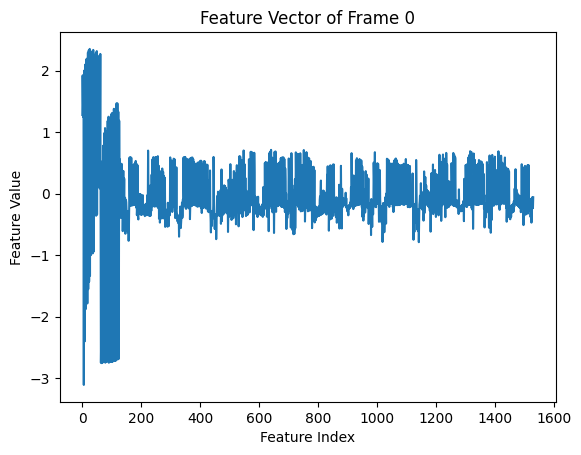

In [ ]:
import matplotlib.pyplot as plt

#Plot of the first feature vector 
plt.plot(X_train[0])
plt.title('Feature Vector of Frame 0')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# split the combined data into training and temporary data (for validation and test sets)
X_train, X_temp, y_train, y_temp = train_test_split(X_train_combined, y_train_combined, test_size=0.3, random_state=42)

# split the temporary data into validation and test sets (50% of the temp data each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# output the shapes of the splits
print("Training data shape (X_train):", X_train.shape)
print("Training labels shape (y_train):", y_train.shape)
print("Validation data shape (X_val):", X_val.shape)
print("Validation labels shape (y_val):", y_val.shape)
print("Test data shape (X_test):", X_test.shape)
print("Test labels shape (y_test):", y_test.shape)


Training data shape (X_train): (24248, 1530)
Training labels shape (y_train): (24248, 30)
Validation data shape (X_val): (5196, 1530)
Validation labels shape (y_val): (5196, 30)
Test data shape (X_test): (5196, 1530)
Test labels shape (y_test): (5196, 30)


In [7]:
print(X_train.shape)
print(y_train.shape)
print(y_val.shape)

(24248, 1530)
(24248, 30)
(5196, 30)


In [ ]:
import numpy as np

# Check the shape and type of X_train and y_train
print(f"X_train type: {type(X_train)}")
print(f"y_train type: {type(y_train)}")

# Ensures X_train and y_train are NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Check if they are now NumPy arrays
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>
X_train shape: (27712, 1530)
y_train shape: (27712, 30)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
model = Sequential([
    Dense(512, input_dim=(1530), activation='relu'),  # Input layer with 1467 features
    Dense(256, activation='relu'),  # Hidden layer
    Dense(128, activation='relu'),  # Hidden layer
    Dense(30, activation='softmax')  # Output layer with 30 classes (one per action)
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])


loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation loss: {loss}")
print(f"Validation accuracy: {accuracy}")

# Save the model
model.save('sign_language_model2.h5')



Epoch 1/50
327/758 [===========>..................] - ETA: 4s - loss: 1.5807 - accuracy: 0.6433

KeyboardInterrupt: 

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               783872    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 30)                3870      
                                                                 
Total params: 951966 (3.63 MB)
Trainable params: 951966 (3.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


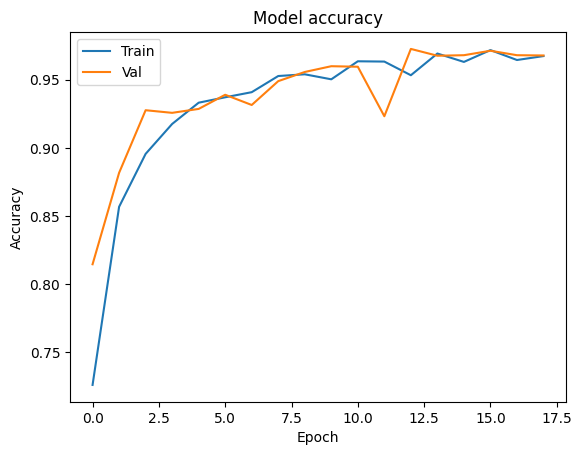

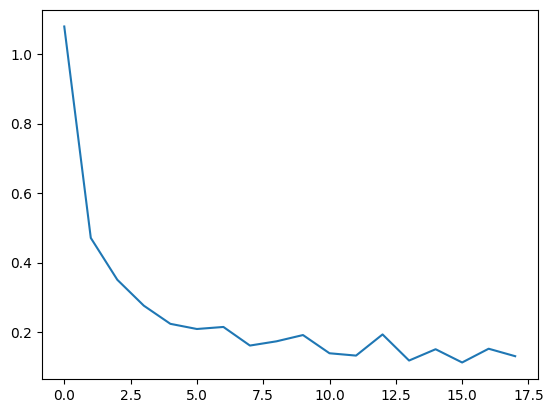

In [ ]:
import matplotlib.pyplot as plt

# plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# plot training & validation loss values
plt.plot(history.history['loss'])


217/217 [==============================] - 1s 2ms/step
Classification Report:
               precision    recall  f1-score   support

         all     0.9596    0.9406    0.9500       101
      before     0.9034    0.9695    0.9353       164
       black     0.9773    0.9247    0.9503        93
        book     0.9778    0.9167    0.9462        48
       candy     0.9531    0.8652    0.9071       141
       chair     1.0000    0.9600    0.9796        75
     clothes     0.8958    0.9348    0.9149        46
    computer     0.9379    0.9497    0.9437       159
        cool     0.9167    0.9333    0.9249       165
      cousin     0.9933    0.9610    0.9769       154
        deaf     0.9072    0.9778    0.9412        90
       drink     0.9191    0.9755    0.9464       163
        fine     0.8796    1.0000    0.9360        95
      finish     0.9455    0.8525    0.8966        61
          go     0.8976    0.9371    0.9169       159
        help     0.9416    0.9667    0.9539       150
  

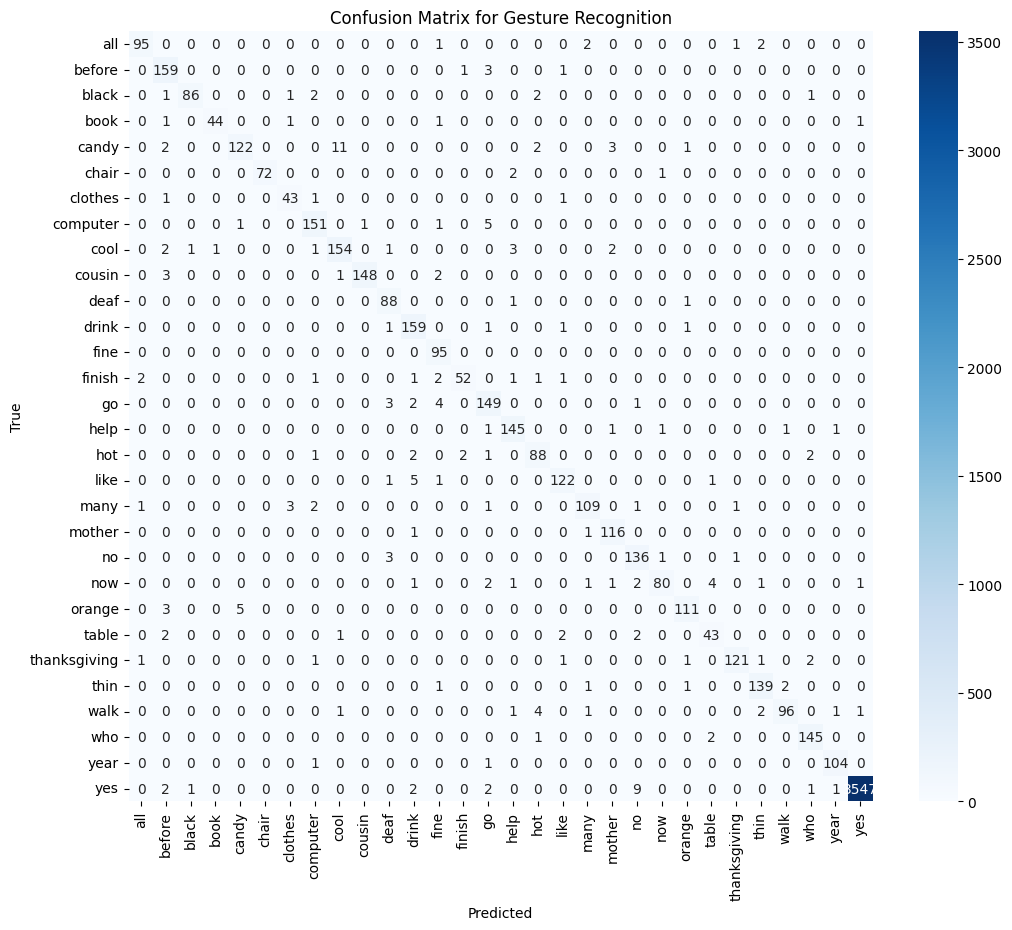


Evaluation complete!
Classification report saved as 'classification_report_gestures.txt'
Confusion matrix saved as 'confusion_matrix_gestures.csv' and 'confusion_matrix_gestures.png'


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Load the model
model = tf.keras.models.load_model('sign_language_model2.h5')

# make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# generate the classification report
report = classification_report(y_true, y_pred_classes, target_names=labels, digits=4)
print("Classification Report:\n", report)

# Save the classification report to a file
with open("classification_report_gestures.txt", "w") as f:
    f.write(report)

# Print misclassified indices
misclassified_indices = np.where(y_pred_classes != y_true)[0]
print(f"\nNumber of misclassified samples: {len(misclassified_indices)}")
print("Misclassified indices:", misclassified_indices)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Save the confusion matrix as a CSV file
np.savetxt("confusion_matrix_gestures.csv", conf_matrix, delimiter=",")

# Plot the confusion matrix 
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Gesture Recognition')
plt.savefig("confusion_matrix_gestures.png")  
plt.show()

print("\nEvaluation complete!")
print("Classification report saved as 'classification_report_gestures.txt'")
print("Confusion matrix saved as 'confusion_matrix_gestures.csv' and 'confusion_matrix_gestures.png'")


RNN run previous code until you combine the data together and then run the below

In [ ]:
import numpy as np

# define the sequence length
sequence_length = 30
num_features = 1530

# function to create sequences from data and labels
def create_sequences(data, labels, sequence_length):
    data_sequences = []
    label_sequences = []
    for i in range(0, data.shape[0], sequence_length):
        if i + sequence_length <= data.shape[0]:
            # create sequence of 30 frames from the data
            data_sequence = data[i:i + sequence_length]
            label_sequence = labels[i + sequence_length - 1]  # Use the label of the last frame in the sequence
            
            # append the sequence and its corresponding label
            data_sequences.append(data_sequence)
            label_sequences.append(label_sequence)
    
    return np.array(data_sequences), np.array(label_sequences)


# create sequences for both the x and y 
X_train_reshaped, y_train_reshaped = create_sequences(X_train, y_train, sequence_length)
X_val_reshaped, y_val_reshaped = create_sequences(X_val, y_val, sequence_length)

print(f"X_train_reshaped shape: {X_train_reshaped.shape}")
print(f"y_train_reshaped shape: {y_train_reshaped.shape}")
print(f"X_val_reshaped shape: {X_val_reshaped.shape}")
print(f"y_val_reshaped shape: {y_val_reshaped.shape}")


X_train_reshaped shape: (808, 30, 1530)
y_train_reshaped shape: (808, 30)
X_val_reshaped shape: (173, 30, 1530)
y_val_reshaped shape: (173, 30)


In [ ]:
# reshaping the labels to match the output format (1 label per sequence)
y_train_reshaped = np.argmax(y_train_reshaped, axis=2)  # choose the label for the last time step
y_val_reshaped = np.argmax(y_val_reshaped, axis=2)  # choose the label for the last time step


In [19]:
print(y_train_reshaped.shape)

(808, 30)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(30, 1530)),  # 30 time steps, 1530 features per time step
    tf.keras.layers.LSTM(64, return_sequences=False), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(30, activation='softmax')  # Output 30 classes
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_reshaped, y_train_reshaped, 
                    epochs=20, 
                    batch_size=32, 
                    validation_data=(X_val_reshaped, y_val_reshaped),
                    callbacks=[early_stopping])

# evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val_reshaped, y_val_reshaped)
print(f"Validation loss: {loss}")
print(f"Validation accuracy: {accuracy}")

# save the model
model.save('RNN.h5')


Epoch 1/20
26/26 [==============================] - 6s 115ms/step - loss: 2.5327 - accuracy: 0.4913 - val_loss: 2.3829 - val_accuracy: 0.4740
Epoch 2/20
26/26 [==============================] - 2s 91ms/step - loss: 1.9902 - accuracy: 0.5285 - val_loss: 2.0352 - val_accuracy: 0.4740
Epoch 3/20
26/26 [==============================] - 2s 92ms/step - loss: 1.6765 - accuracy: 0.5334 - val_loss: 1.8369 - val_accuracy: 0.4913
Epoch 4/20
26/26 [==============================] - 2s 95ms/step - loss: 1.5386 - accuracy: 0.5668 - val_loss: 1.7840 - val_accuracy: 0.4855
Epoch 5/20
26/26 [==============================] - 2s 95ms/step - loss: 1.4627 - accuracy: 0.5743 - val_loss: 1.7589 - val_accuracy: 0.4971
Epoch 6/20
26/26 [==============================] - 3s 98ms/step - loss: 1.3850 - accuracy: 0.6151 - val_loss: 1.7182 - val_accuracy: 0.5202
Epoch 7/20
26/26 [==============================] - 2s 91ms/step - loss: 1.3065 - accuracy: 0.6448 - val_loss: 1.7047 - val_accuracy: 0.5434
Epoch 8/20
2

c:\Users\shaga\miniconda3\envs\mediapipe-env\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


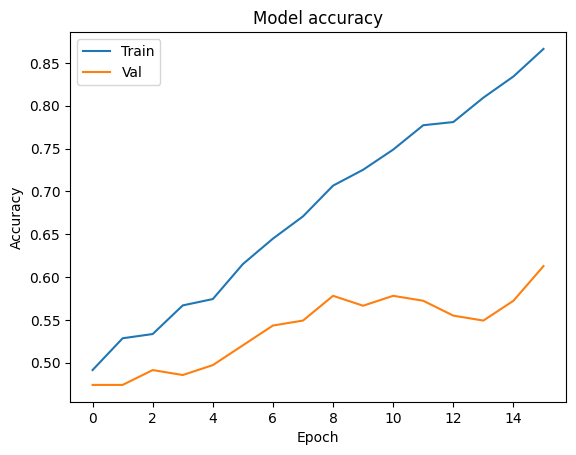

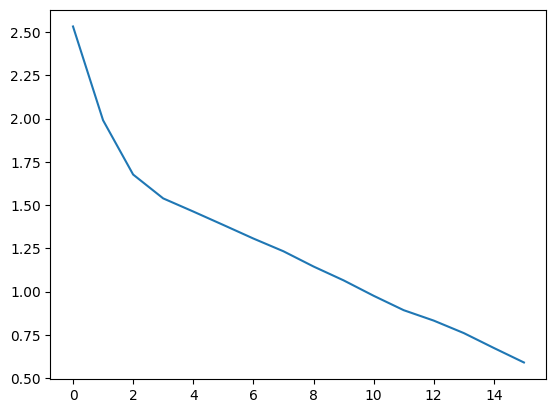

In [ ]:
import matplotlib.pyplot as plt

# plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# plot training & validation loss values
plt.plot(history.history['loss'])

6/6 [==============================] - 1s 30ms/step
Unique classes in y_true: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Unique classes in y_pred_classes: [ 0  1  4  7  8  9 10 11 12 14 15 17 18 20 24 25 26 27 28 29]
Classification Report:
               precision    recall  f1-score   support

         all     0.0000    0.0000    0.0000         4
      before     0.0000    0.0000    0.0000         3
       black     0.0000    0.0000    0.0000         1
        book     0.0000    0.0000    0.0000         2
       candy     0.0000    0.0000    0.0000         1
       chair     0.0000    0.0000    0.0000         2
     clothes     0.0000    0.0000    0.0000         2
    computer     0.0000    0.0000    0.0000         2
        cool     0.1667    0.1667    0.1667         6
      cousin     0.1818    1.0000    0.3077         2
        deaf     0.0000    0.0000    0.0000         6
       drink     0.2353    0.6667    0.3478         6
      

c:\Users\shaga\miniconda3\envs\mediapipe-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shaga\miniconda3\envs\mediapipe-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shaga\miniconda3\envs\mediapipe-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

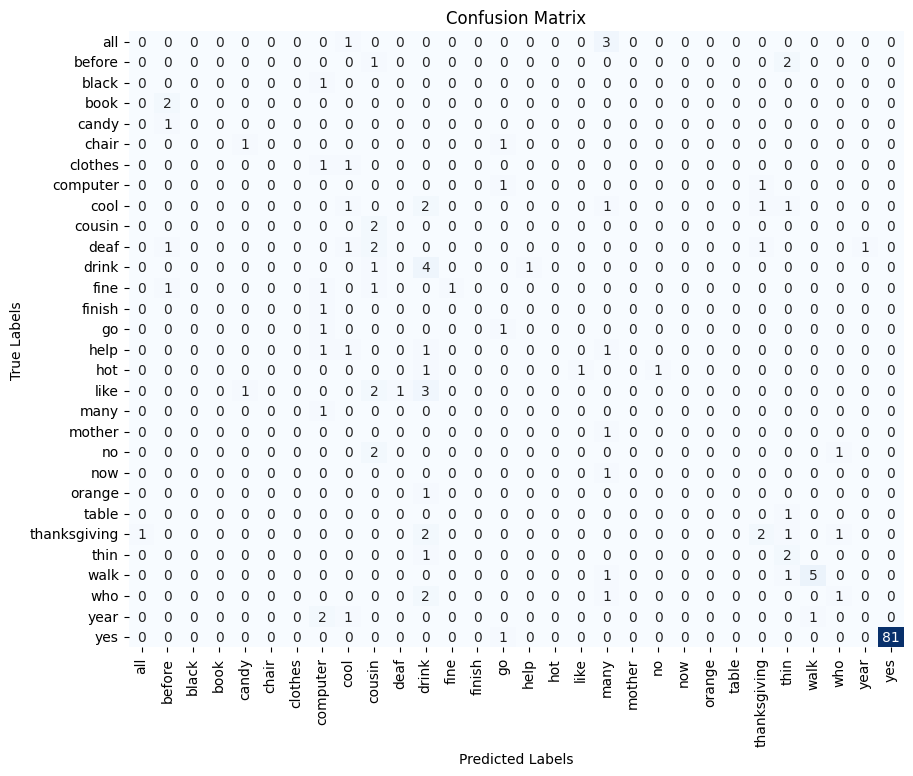


Evaluation complete!


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Labels for 30 classes
labels = ["all", "before", "black", "book", "candy", "chair", "clothes", "computer", "cool", "cousin", 
          "deaf", "drink", "fine", "finish", "go", "help", "hot", "like", "many", "mother", "no", "now", 
          "orange", "table", "thanksgiving", "thin", "walk", "who", "year", "yes"]


model = tf.keras.models.load_model('RNN.h5')

# get predictions from the model 
y_pred = model.predict(X_val_reshaped)

# convert the predicted probabilities to class indices for each sequence
y_pred_classes = np.argmax(y_pred, axis=1)  

# extract the sequence level labels from y_val_reshaped
y_true = np.argmax(y_val_reshaped, axis=1)  

# make sure that y_true and y_pred_classes have the same shape
y_true = y_true.flatten()
y_pred_classes = y_pred_classes.flatten()

# check the unique classes in y_true and y_pred_classes
unique_true_classes = np.unique(y_true)
unique_pred_classes = np.unique(y_pred_classes)

# print the number of unique classes in both
print(f"Unique classes in y_true: {unique_true_classes}")
print(f"Unique classes in y_pred_classes: {unique_pred_classes}")

# print the classification report 
report = classification_report(y_true, y_pred_classes, target_names=labels, labels=np.arange(30), digits=4)
print("Classification Report:\n", report)

# print misclassified indices
misclassified_indices = np.where(y_pred_classes != y_true)[0]
print(f"\nNumber of misclassified samples: {len(misclassified_indices)}")
print("Misclassified indices:", misclassified_indices)

# generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# print the confusion matrix 
print("\nConfusion Matrix:")
print(conf_matrix)

# plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("\nEvaluation complete!")


In [25]:
print(f"Shape of y_val_reshaped: {y_val_reshaped.shape}")


Shape of y_val_reshaped: (173, 30)


In [34]:
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 128)           849408    
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 30)                1950      
                                                                 
Total params: 904926 (3.45 MB)
Trainable params: 904926 (3.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
print(f"Shape of y_true: {y_true.shape}")
print(f"Shape of y_pred_classes: {y_pred_classes.shape}")


Shape of y_true: (5190,)
Shape of y_pred_classes: (173,)


No face

In [ ]:
import cv2
import mediapipe as mp
import json
import os
import numpy as np


output_json_path = r"path and name it all landmarks no face.json"


json_file_path = r"use update with pathformatted_data.json"
with open(json_file_path, 'r') as file:
    video_data = json.load(file)


mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.7)

mp_drawing = mp.solutions.drawing_utils


def interpolate_landmarks(prev_landmarks, next_landmarks):
    if prev_landmarks and next_landmarks:
        return [
            [
                np.mean([prev_point[0], next_point[0]]),
                np.mean([prev_point[1], next_point[1]]),
                np.mean([prev_point[2], next_point[2]])
            ]
            for prev_point, next_point in zip(prev_landmarks, next_landmarks)
        ]
    return prev_landmarks or next_landmarks


def extract_landmarks(video_path, gloss_label, video_index):
    print(f"Attempting to open video file: {video_path}")
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_path}")
        return []

    frames = []
    previous_hand_landmarks = None
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print(f"End of video or error reading frame for {video_path}")
            break
        
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        
        hand_results = hands.process(rgb_frame)
        
       
        hand_landmarks = []
        if hand_results.multi_hand_landmarks and hand_results.multi_handedness:
            print(f"Hands detected in frame")
            for hand_landmarks_single, hand_handedness in zip(hand_results.multi_hand_landmarks, hand_results.multi_handedness):
              
                hand_coords = [
                    [landmark.x, landmark.y, landmark.z]
                    for landmark in hand_landmarks_single.landmark
                ]
                hand_label = hand_handedness.classification[0].label  
                hand_landmarks.append({
                    "label": hand_label,
                    "landmarks": hand_coords
                })
                
         
                mp_drawing.draw_landmarks(frame, hand_landmarks_single, mp_hands.HAND_CONNECTIONS)
                cv2.putText(frame, hand_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        else:
            print(f"No hands detected in frame")
            if previous_hand_landmarks:
                print("Interpolating missing hand landmarks...")
                hand_landmarks = previous_hand_landmarks

  
        if previous_hand_landmarks and not hand_landmarks:
            hand_landmarks = interpolate_landmarks(previous_hand_landmarks, hand_landmarks)
        
        previous_hand_landmarks = hand_landmarks


        frames.append({
            "video_id": f"video_{video_index}",
            "action": gloss_label,
            "landmarks": {
                "hand": hand_landmarks if hand_landmarks else None
            }
        })
        
     
        cv2.imshow("Video Frame", frame)
        
      
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("Display window closed by user")
            break
    
    cap.release()
    cv2.destroyAllWindows()
    return frames


all_frames = []


for video_index, video_info in enumerate(video_data):
    video_path = video_info['video_path']
    gloss_label = video_info['gloss']
    
    print(f"Processing video: {video_path} with action: {gloss_label}")
    
   
    video_frames = extract_landmarks(video_path, gloss_label, video_index)
    
  
    all_frames.extend(video_frames)


output_data = {
    "frames": all_frames
}


with open(output_json_path, 'w') as json_file:
    json.dump(output_data, json_file, indent=4)

print(f"All landmarks saved to {output_json_path}")

In [ ]:
import json

input_json_path = r"path to all_landmarks_no_face.json"
output_json_path = r"path to all_landmarks_cleaned_hands_only.json"

with open(input_json_path, 'r') as file:
    data = json.load(file)

cleaned_frames = []
for frame in data["frames"]:
    hand_landmarks = frame["landmarks"].get("hand")
    
    if hand_landmarks is not None:
        cleaned_frames.append(frame)

output_data = {"frames": cleaned_frames}

with open(output_json_path, 'w') as file:
    json.dump(output_data, file, indent=4)

print(f"Cleaned JSON saved to {output_json_path}")


Cleaned JSON saved to C:\Users\shaga\Desktop\machn learning\all_landmarks_cleaned_hands_only.json


In [2]:
import json
import numpy as np


with open('all_landmarks_cleaned_hands_only.json', 'r') as file:
    data = json.load(file)


labels = [
    "all", "before", "black", "book", "candy", "chair", "clothes", "computer", "cool", "cousin", 
    "deaf", "drink", "fine", "finish", "go", "help", "hot", "like", "many", "mother", "no", "now", 
    "orange", "table", "thanksgiving", "thin", "walk", "who", "year", "yes"
]


label_to_index = {label: index for index, label in enumerate(labels)}

def flatten_landmarks(landmarks, max_length=126):  
    flattened = []
    for landmark in landmarks:
        if isinstance(landmark, list) and len(landmark) == 3:  
            try:
                flattened.extend([float(coord) for coord in landmark])  
            except ValueError:
                flattened.extend([0.0, 0.0, 0.0])  
        else:
            flattened.extend([0.0, 0.0, 0.0])  
    while len(flattened) < max_length:
        flattened.append(0.0) 
    return flattened[:max_length]  


X_train = []
y_train = []


for frame in data['frames']:

    action = frame.get('action', 'unknown')
    landmarks = frame.get('landmarks', {})
    right_hand_landmarks = []
    left_hand_landmarks = []
    if 'hand' in landmarks:
        for hand in landmarks['hand']:
            if hand.get('label') == 'Right':
                right_hand_landmarks = hand.get('landmarks', [])
            elif hand.get('label') == 'Left':
                left_hand_landmarks = hand.get('landmarks', [])
    right_hand_flat = flatten_landmarks(right_hand_landmarks, max_length=63)  # 63 for right hand
    left_hand_flat = flatten_landmarks(left_hand_landmarks, max_length=63)  # 63 for left hand

    # combine both hands' landmarks 
    features = right_hand_flat + left_hand_flat
    X_train.append(features)
    label_index = label_to_index.get(action, -1)  # same as previous
    if label_index != -1:
        one_hot_label = np.zeros(len(labels))
        one_hot_label[label_index] = 1
        y_train.append(one_hot_label)
    else:
        y_train.append(np.zeros(len(labels)))

X_train = np.array(X_train)
y_train = np.array(y_train)

print("X_train shape:", X_train.shape)  
print("y_train shape:", y_train.shape)  # shapes must be ,126 for x train and ,30 for y train


X_train shape: (17608, 126)
y_train shape: (17608, 30)


In [ ]:
# checks if every element has 3 coordinates per landmark (x, y, z)
for i, sample in enumerate(X_train):
    for j in range(0, len(sample), 3):
        if len(sample[j:j+3]) != 3:
            print(f"Error: Sample {i} has incorrect number of coordinates at position {j}.")
            break


In [ ]:
import pickle
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
# Save the scaler to a file
scaler_path = r" path to save scaler_hands_only.pkl" 
with open(scaler_path, 'wb') as file:
    pickle.dump(scaler, file)

print("Scaler has been saved successfully!")


Scaler has been saved successfully!


In [37]:
print(X_train[0])

[ 1.27827473  1.92045219  1.62745228  1.24553895  1.92302813 -3.12736609  1.20723878  1.99948715 -2.41897988  1.1894333   2.09389181 -1.89305363  1.16620063  2.1774578  -1.53155846  1.26070567
  2.19193604 -1.79870816  1.24903433  2.28925517 -1.56353344  1.21472303  2.32792246 -1.43982132  1.18922215  2.34676715 -1.34469538  1.29071337  2.2017959  -1.00735717  1.28175697  2.28292635
 -0.97049401  1.24699178  2.31246563 -0.97850226  1.21690061  2.33151822 -0.9518662   1.30299732  2.17965281 -0.25444895  1.29648077  2.2513288  -0.35229523  1.26373325  2.28596153 -0.36119017
  1.22958941  2.31243243 -0.34181756  1.30921681  2.14367448  0.31021033  1.30337124  2.20468618  0.11851573  1.27691563  2.24156677  0.0851754   1.25206091  2.26677111  0.09206893 -2.74729529
 -2.37639452 -0.27073147 -2.75387958 -2.31890681  0.52650536 -2.74509545 -2.20733646  0.78062671 -2.72498634 -2.11335113  0.98202456 -2.69363835 -2.04465036  1.06510306 -2.74686837 -2.05055334
  0.68000589 -2.73229326 -1.9237043

In [ ]:
import numpy as np
import random
from keras.utils import to_categorical


def flatten_landmarks(landmarks, max_length=126):  
    flattened = []
    for landmark in landmarks:
        if isinstance(landmark, list) and len(landmark) == 3:
            try:
                flattened.extend([float(coord) for coord in landmark])  
            except ValueError:
                flattened.extend([0.0, 0.0, 0.0])  
        else:
            flattened.extend([0.0, 0.0, 0.0])  
    while len(flattened) < max_length:
        flattened.append(0.0)
    return flattened[:max_length]
 

def scale_landmarks(flattened_landmarks, scale_factor):
    augmented_landmarks = []
    for i in range(0, len(flattened_landmarks), 3):
        if i + 2 < len(flattened_landmarks):  
            x, y, z = flattened_landmarks[i:i+3]
            augmented_landmarks.extend([x * scale_factor, y * scale_factor, z * scale_factor])
    return augmented_landmarks

def translate_landmarks(flattened_landmarks, translation_range):
    translation_x = np.random.uniform(-translation_range, translation_range)
    translation_y = np.random.uniform(-translation_range, translation_range)
    translation_z = np.random.uniform(-translation_range, translation_range)
    
    augmented_landmarks = []
    for i in range(0, len(flattened_landmarks), 3):
        if i + 2 < len(flattened_landmarks):  
            x, y, z = flattened_landmarks[i:i+3]
            augmented_landmarks.extend([x + translation_x, y + translation_y, z + translation_z])
    return augmented_landmarks

def rotate_landmarks_2d(flattened_landmarks, angle):
    angle_rad = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])
    
    augmented_landmarks = []
    for i in range(0, len(flattened_landmarks), 3):
        if i + 2 < len(flattened_landmarks):  
            x, y, z = flattened_landmarks[i:i+3]
            coords = np.array([x, y])
            rotated_coords = np.dot(rotation_matrix, coords)
            augmented_landmarks.extend([rotated_coords[0], rotated_coords[1], z]) 
    return augmented_landmarks



def augment_landmarks(flattened_landmarks, scale_range=(0.8, 1.2), translation_range=5, rotation_range=(-30, 30)):
    scale_factor = np.random.uniform(scale_range[0], scale_range[1])
    augmented_landmarks = scale_landmarks(flattened_landmarks, scale_factor)
    augmented_landmarks = translate_landmarks(augmented_landmarks, translation_range)
    angle = np.random.uniform(rotation_range[0], rotation_range[1])  # Random angle
    augmented_landmarks = rotate_landmarks_2d(augmented_landmarks, angle)
    return augmented_landmarks

X_train_augmented = []
y_train_augmented = []

for i, frame in enumerate(data['frames']):  
    right_hand_landmarks = flatten_landmarks(frame['landmarks'].get('hand', []))  
    left_hand_landmarks = flatten_landmarks(frame['landmarks'].get('left', []))  
    combined_landmarks = right_hand_landmarks + left_hand_landmarks 
    augmented_landmarks = augment_landmarks(combined_landmarks)
    while len(augmented_landmarks) < 126:
        augmented_landmarks.append(0.0)  
    
    augmented_landmarks = augmented_landmarks[:126]

    X_train_augmented.append(augmented_landmarks)

    action = frame['action']
    label = label_to_index.get(action, -1)
    if label != -1:
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)


y_train_augmented = to_categorical(y_train_augmented, num_classes=len(label_to_index))


X_train_combined = np.concatenate([X_train, X_train_augmented], axis=0)
y_train_combined = np.concatenate([y_train, y_train_augmented], axis=0)


print("Combined X_train shape:", X_train_combined.shape)  # shape should be ,126
print("Combined y_train shape:", y_train_combined.shape)  # shaspe should be ,30


Combined X_train shape: (35216, 126)
Combined y_train shape: (35216, 30)


In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X_train, X_temp, y_train, y_temp = train_test_split(X_train_combined, y_train_combined, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training data shape (X_train):", X_train.shape)
print("Training labels shape (y_train):", y_train.shape)
print("Validation data shape (X_val):", X_val.shape)
print("Validation labels shape (y_val):", y_val.shape)
print("Test data shape (X_test):", X_test.shape)
print("Test labels shape (y_test):", y_test.shape)


Training data shape (X_train): (24651, 126)
Training labels shape (y_train): (24651, 30)
Validation data shape (X_val): (5282, 126)
Validation labels shape (y_val): (5282, 30)
Test data shape (X_test): (5283, 126)
Test labels shape (y_test): (5283, 30)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential([
    Dense(512, input_dim=(126), activation='relu'),  
    Dense(256, activation='relu'), 
    Dense(128, activation='relu'),  
    Dense(30, activation='softmax') 
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])



loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation loss: {loss}")
print(f"Validation accuracy: {accuracy}")

# Save the model
model.save('sign_language_model_hands_only.h5')



Epoch 1/50
771/771 [==============================] - 3s 3ms/step - loss: 2.9076 - accuracy: 0.1791 - val_loss: 2.5474 - val_accuracy: 0.2747
Epoch 2/50
771/771 [==============================] - 2s 3ms/step - loss: 2.4252 - accuracy: 0.3051 - val_loss: 2.3295 - val_accuracy: 0.3251
Epoch 3/50
771/771 [==============================] - 2s 3ms/step - loss: 2.2496 - accuracy: 0.3554 - val_loss: 2.1943 - val_accuracy: 0.3701
Epoch 4/50
771/771 [==============================] - 2s 3ms/step - loss: 2.1470 - accuracy: 0.3861 - val_loss: 2.1086 - val_accuracy: 0.4055
Epoch 5/50
771/771 [==============================] - 2s 3ms/step - loss: 2.0845 - accuracy: 0.4060 - val_loss: 2.0793 - val_accuracy: 0.4093
Epoch 6/50
771/771 [==============================] - 2s 3ms/step - loss: 2.0279 - accuracy: 0.4228 - val_loss: 2.0225 - val_accuracy: 0.4317
Epoch 7/50
771/771 [==============================] - 2s 3ms/step - loss: 1.9881 - accuracy: 0.4340 - val_loss: 2.0185 - val_accuracy: 0.4307
Epoch 

c:\Users\shaga\miniconda3\envs\mediapipe-env\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
input_shape = (X_train_reshaped.shape[0])

print(input_shape)

27712


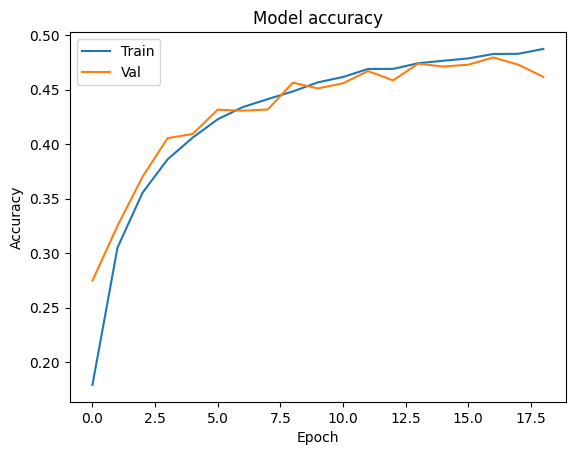

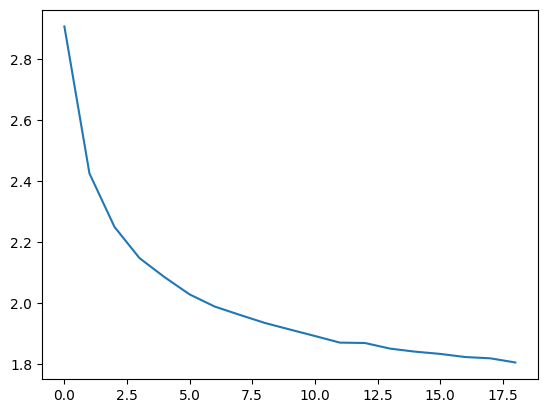

In [ ]:
import matplotlib.pyplot as plt

# plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# plot training & validation loss values
plt.plot(history.history['loss'])

166/166 [==============================] - 0s 1ms/step
Classification Report:
               precision    recall  f1-score   support

         all     0.6053    0.4726    0.5308       146
      before     0.6250    0.3909    0.4810       243
       black     0.9344    0.3851    0.5455       148
        book     0.8235    0.2887    0.4275        97
       candy     0.8878    0.4603    0.6063       189
       chair     0.9565    0.3894    0.5535       113
     clothes     0.9630    0.3714    0.5361        70
    computer     0.1482    0.6611    0.2421       239
        cool     0.9298    0.4862    0.6386       218
      cousin     0.0978    0.7458    0.1730       236
        deaf     0.9167    0.4615    0.6140       143
       drink     0.8739    0.4444    0.5892       234
        fine     0.9324    0.4631    0.6188       149
      finish     0.9767    0.4000    0.5676       105
          go     0.9389    0.5212    0.6703       236
        help     0.8593    0.4874    0.6220       238
  

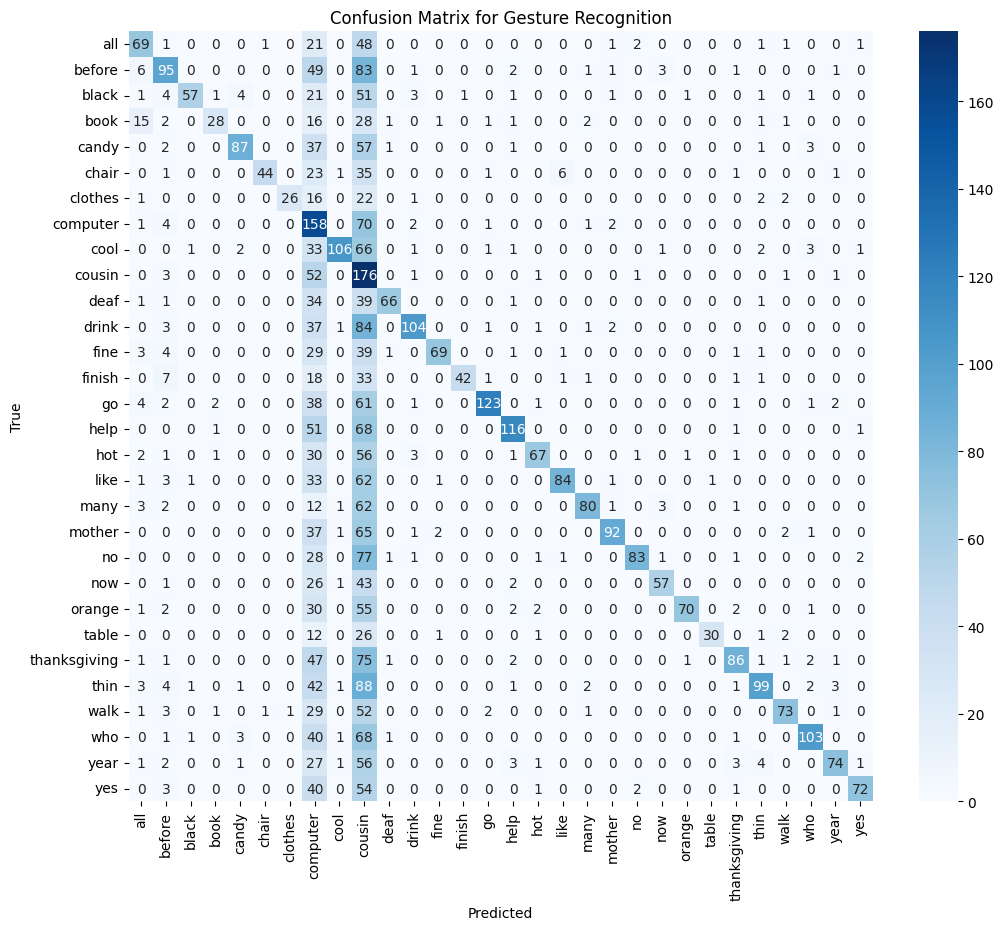


Evaluation complete!
Classification report saved as 'classification_report_gestures.txt'
Confusion matrix saved as 'confusion_matrix_gestures.csv' and 'confusion_matrix_gestures.png'


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


model = tf.keras.models.load_model('sign_language_model_hands_only.h5')

# make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# generate the classification report
report = classification_report(y_true, y_pred_classes, target_names=labels, digits=4)
print("Classification Report:\n", report)

# save the classification report to a file
with open("classification_report_gestures_hands_only.txt", "w") as f:
    f.write(report)

# print misclassified indices
misclassified_indices = np.where(y_pred_classes != y_true)[0]
print(f"\nNumber of misclassified samples: {len(misclassified_indices)}")
print("Misclassified indices:", misclassified_indices)

# generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# save the confusion matrix 
np.savetxt("confusion_matrix_gestures_hands_only.csv", conf_matrix, delimiter=",")

# plot the confusion matrix 
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Gesture Recognition')
plt.savefig("confusion_matrix_gestures_hands_only.png")  # Save as an image file
plt.show()

print("\nEvaluation complete!")
print("Classification report saved as 'classification_report_gestures.txt'")
print("Confusion matrix saved as 'confusion_matrix_gestures.csv' and 'confusion_matrix_gestures.png'")


RNN no Face again run previous code until training combined then run below

In [ ]:
import numpy as np


sequence_length = 30
num_features = 126

# Function to create sequences from data and labels
def create_sequences(data, labels, sequence_length):
    data_sequences = []
    label_sequences = []
    for i in range(0, data.shape[0], sequence_length):
        if i + sequence_length <= data.shape[0]:
            data_sequence = data[i:i + sequence_length]
            label_sequence = labels[i + sequence_length - 1]  
            data_sequences.append(data_sequence)
            label_sequences.append(label_sequence)
    
    return np.array(data_sequences), np.array(label_sequences)

X_train_reshaped, y_train_reshaped = create_sequences(X_train, y_train, sequence_length)
X_val_reshaped, y_val_reshaped = create_sequences(X_val, y_val, sequence_length)

print(f"X_train_reshaped shape: {X_train_reshaped.shape}")
print(f"y_train_reshaped shape: {y_train_reshaped.shape}")
print(f"X_val_reshaped shape: {X_val_reshaped.shape}")
print(f"y_val_reshaped shape: {y_val_reshaped.shape}")


X_train_reshaped shape: (821, 30, 126)
y_train_reshaped shape: (821, 30)
X_val_reshaped shape: (176, 30, 126)
y_val_reshaped shape: (176, 30)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(30, 126)),  
    tf.keras.layers.LSTM(64, return_sequences=False), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(30, activation='softmax')  
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_reshaped, y_train_reshaped, 
                    epochs=20, 
                    batch_size=32, 
                    validation_data=(X_val_reshaped, y_val_reshaped),
                    callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_val_reshaped, y_val_reshaped)
print(f"Validation loss: {loss}")
print(f"Validation accuracy: {accuracy}")

# Save the model
model.save('RNN_no_face.h5')


Epoch 1/20
26/26 [==============================] - 4s 57ms/step - loss: 3.3981 - accuracy: 0.0365 - val_loss: 3.3836 - val_accuracy: 0.0455
Epoch 2/20
26/26 [==============================] - 1s 33ms/step - loss: 3.3189 - accuracy: 0.0816 - val_loss: 3.3799 - val_accuracy: 0.0341
Epoch 3/20
26/26 [==============================] - 1s 33ms/step - loss: 3.2524 - accuracy: 0.1023 - val_loss: 3.4143 - val_accuracy: 0.0568
Epoch 4/20
26/26 [==============================] - 1s 33ms/step - loss: 3.1566 - accuracy: 0.1169 - val_loss: 3.4372 - val_accuracy: 0.0398
Epoch 5/20
26/26 [==============================] - 1s 33ms/step - loss: 3.0546 - accuracy: 0.1486 - val_loss: 3.4716 - val_accuracy: 0.0568
Epoch 6/20
26/26 [==============================] - 1s 33ms/step - loss: 2.8897 - accuracy: 0.2010 - val_loss: 3.5062 - val_accuracy: 0.0398
Epoch 7/20
6/6 [==============================] - 0s 11ms/step - loss: 3.3799 - accuracy: 0.0341
Validation loss: 3.3798811435699463
Validation accuracy: 

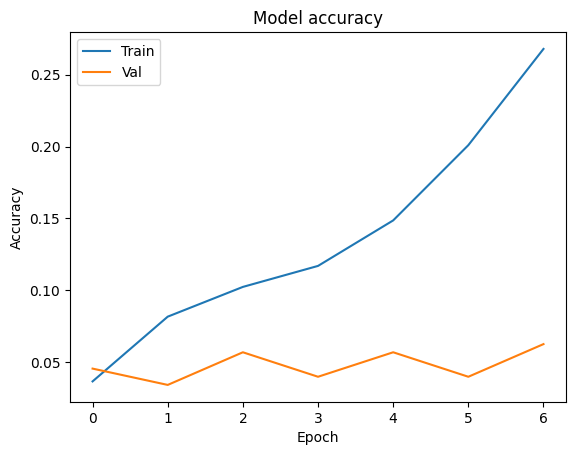

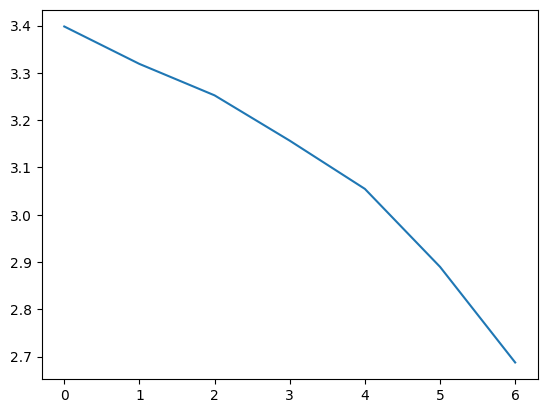

In [ ]:
import matplotlib.pyplot as plt

# plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# plot training & validation loss values
plt.plot(history.history['loss'])

6/6 [==============================] - 1s 11ms/step
Unique classes in y_true: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Unique classes in y_pred_classes: [ 1  7  8  9 11 15 26 28]
Classification Report:
               precision    recall  f1-score   support

         all     0.0000    0.0000    0.0000         4
      before     0.0270    0.1111    0.0435         9
       black     0.0000    0.0000    0.0000         6
        book     0.0000    0.0000    0.0000         3
       candy     0.0000    0.0000    0.0000         9
       chair     0.0000    0.0000    0.0000         3
     clothes     0.0000    0.0000    0.0000         4
    computer     0.0164    0.0833    0.0274        12
        cool     0.2000    0.1250    0.1538         8
      cousin     0.0244    0.1667    0.0426         6
        deaf     0.0000    0.0000    0.0000         5
       drink     0.0741    0.2857    0.1176         7
        fine     0.0000    0.0000    0.000

c:\Users\shaga\miniconda3\envs\mediapipe-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shaga\miniconda3\envs\mediapipe-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shaga\miniconda3\envs\mediapipe-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

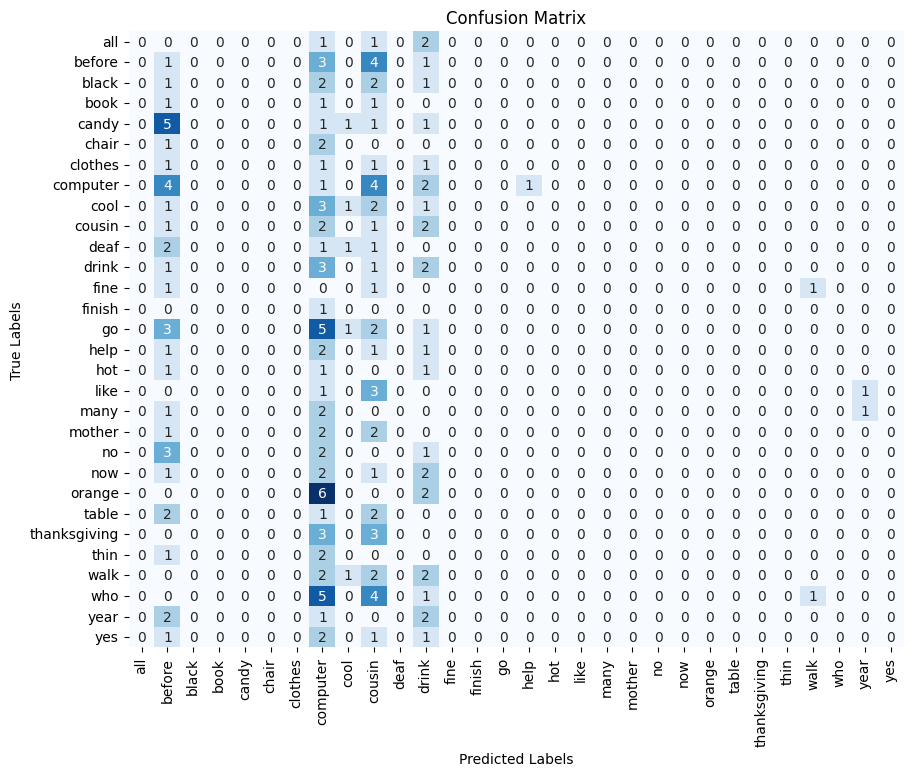


Evaluation complete!


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Labels for 30 classes 
labels = ["all", "before", "black", "book", "candy", "chair", "clothes", "computer", "cool", "cousin", 
          "deaf", "drink", "fine", "finish", "go", "help", "hot", "like", "many", "mother", "no", "now", 
          "orange", "table", "thanksgiving", "thin", "walk", "who", "year", "yes"]

model = tf.keras.models.load_model('RNN_no_face.h5')

y_pred = model.predict(X_val_reshaped)

y_pred_classes = np.argmax(y_pred, axis=1)  

y_true = np.argmax(y_val_reshaped, axis=1)  


y_true = y_true.flatten()
y_pred_classes = y_pred_classes.flatten()


unique_true_classes = np.unique(y_true)
unique_pred_classes = np.unique(y_pred_classes)


print(f"Unique classes in y_true: {unique_true_classes}")
print(f"Unique classes in y_pred_classes: {unique_pred_classes}")

# Print the classification report with all 30 labels
report = classification_report(y_true, y_pred_classes, target_names=labels, labels=np.arange(30), digits=4)
print("Classification Report:\n", report)

# Print misclassified indices
misclassified_indices = np.where(y_pred_classes != y_true)[0]
print(f"\nNumber of misclassified samples: {len(misclassified_indices)}")
print("Misclassified indices:", misclassified_indices)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Print the confusion matrix as text in the console
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Display the confusion matrix image 
plt.show()

print("\nEvaluation complete!")